In [29]:
# Import important Libraries
import nselib
from nselib import capital_market
import yfinance as yf
from datetime import date
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

# 1. Data Acquisition and Preparation:

In [4]:
# extracting the sybles of company
NSE_Equity = capital_market.nifty50_equity_list()
NSE_Equity["Symbol"] = NSE_Equity["Symbol"] + ".NS" 
NSE_Equity.head()

,Company Name,Industry,Symbol
0,Adani Enterprises Ltd.,Metals & Mining,ADANIENT.NS
1,Adani Ports and Special Economic Zone Ltd.,Services,ADANIPORTS.NS
2,Apollo Hospitals Enterprise Ltd.,Healthcare,APOLLOHOSP.NS
3,Asian Paints Ltd.,Consumer Durables,ASIANPAINT.NS
4,Axis Bank Ltd.,Financial Services,AXISBANK.NS


In [ ]:
#creating a list of symbols
NSE_Equity_Symbol = list(NSE_Equity["Symbol"])
NSE_Equity_Symbol

In [7]:
#extracting the market cap data through symble
Market_Cap = []
for symbol in NSE_Equity_Symbol:
    ticker = yf.Ticker(symbol)
    info = ticker.info
    market_cap = info.get('marketCap')
    Market_Cap.append({"Symbol" : symbol, "Market_Cap":market_cap})

Market_Cap_df = pd.DataFrame(Market_Cap)
Market_Cap_df.head()

,Symbol,Market_Cap
0,ADANIENT.NS,3389790093312
1,ADANIPORTS.NS,3212128288768
2,APOLLOHOSP.NS,918182166528
3,ASIANPAINT.NS,2781482057728
4,AXISBANK.NS,3636188676096


In [ ]:
# analysing top 20 according to market cap
Stock_Symbol = list(Market_Cap_df.sort_values(by = "Market_Cap", ascending=False).head(20)["Symbol"])
Stock_Symbol

In [52]:
# extracting data for top 20 company from 2019 to 2023
start_date = "2019-01-01"
end_date = "2023-12-31"

Stocks = pd.DataFrame()
for i in Stock_Symbol:
    ticker = yf.Ticker(i)
    Data = ticker.history(start=start_date, end=end_date)
    Data["Symbol"] = i 
    Stocks = pd.concat([Stocks, Data])
Stocks.reset_index(inplace=True)
Stocks.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Symbol
0,2019-01-01 00:00:00+05:30,1008.168089,1010.004795,994.594411,1004.360229,4873335,0.0,0.0,RELIANCE.NS
1,2019-01-02 00:00:00+05:30,998.536650,1009.736069,986.441307,991.279480,7814409,0.0,0.0,RELIANCE.NS
2,2019-01-03 00:00:00+05:30,992.264993,998.626239,976.675483,979.049744,8144143,0.0,0.0,RELIANCE.NS
3,2019-01-04 00:00:00+05:30,983.215909,989.532359,968.611917,984.335815,9258272,0.0,0.0,RELIANCE.NS
4,2019-01-07 00:00:00+05:30,991.817038,1002.075676,986.441310,989.801147,6030145,0.0,0.0,RELIANCE.NS


In [ ]:
# see the rows of every company
for i in Stock_Symbol:
    print(i,":",Stocks[Stocks["Symbol"] == i].shape)

In [56]:
# Correct date column
Stocks["Date"] = Stocks["Date"].dt.date

In [ ]:
# Calculate cumulative returns for max drawdown calculation
Stocks['Cumulative_Return'] = (1 + Stocks['Stretegy_return']).groupby(Stocks['Symbol']).cumprod()

In [57]:
# converting data frame in csv file
Stocks.to_csv('top_20_stocks.csv',index=False)

In [ ]:
# read the csv file in df
df = pd.read_csv('top_20_stocks.csv', parse_dates=['Date'])

# Ensure the DataFrame is sorted by date for each stock
df = df.sort_values(by=['Symbol', 'Date'])

In [ ]:
# Add a 'Year' column to extract the year from the 'Date' column
df['Year'] = df['Date'].dt.year

# 2. Strategy Implementation and Backtesting:

In [ ]:
# i assume that the Initial capital for backtesting is 100000.0
initial_capital = 100000.0
# List of stocks in the dataset
stocks = df['Symbol'].unique()

# Initialize an empty list to store results
results = []

for stock in stocks:
    # Filter data for the current stock
    stock_data = df[df['Symbol'] == stock].set_index('Date')
    # start this loop for yearly data
    for year in stock_data['Year'].unique():
        y_data = stock_data[stock_data['Year'] == year]

        # DataFrame to store sing
        sing = pd.DataFrame(index=y_data.index)
        sing['signal'] = 0.0
        
        #short moving average
        sing['short_mavg'] = y_data['Close'].rolling(window=50, min_periods=1).mean()
        
        # long  moving average
        sing['long_mavg'] = y_data['Close'].rolling(window=200, min_periods=1).mean()
        
        # Create sing
        sing['signal'][50:] = np.where(sing['short_mavg'][50:] > sing['long_mavg'][50:], 1.0, 0.0)
        
        # Generate trading orders
        sing['posi'] = sing['signal'].diff()
        
        #  position DataFrame
        posi = pd.DataFrame(index=sing.index).fillna(0.0)
        posi['stock'] = 100 * sing['signal']
        
        #  portfolio DataFrame
        port = pd.DataFrame(index=sing.index).fillna(0.0)
        port['stock'] = posi['stock']
        port['holdings'] = posi.multiply(y_data['Close'], axis=0).sum(axis=1)
        port['cash'] = initial_capital - (posi.diff().multiply(y_data['Close'], axis=0)).sum(axis=1).cumsum()
        port['total'] = port['cash'] + port['holdings']
        port['returns'] = port['total'].pct_change()
        
        # Calculate performance metrics
        to_re = port['total'][-1] / port['total'][0] - 1
        annualized_returns = np.mean(port['returns']) * 252
        annualized_volatility = np.std(port['returns']) * np.sqrt(252)
        sh_rat = annualized_returns / annualized_volatility
        m_dr = ((port['total'] / port['total'].cummax()) - 1).min()
        wl_ra = (port['returns'] > 0).sum() / (port['returns'] <= 0).sum()
        n_traders = sing['posi'].abs().sum()
        
        # Store results
        results.append({'Stock': stock,'Year': year,'Total Returns': to_re,'Annualized Returns': annualized_returns,'Max Drawdown': m_dr,
                        'Sharpe Ratio': sh_rat,'Win/Loss Ratio': wl_ra,'Number of Trades': n_traders})

In [ ]:
results_df = pd.DataFrame(results)
print(results_df)

In [64]:
results_df.to_csv('backtesting_results.csv')
results_df.head(8)

,Stock,Year,Total Returns,Annualized Returns,Max Drawdown,Sharpe Ratio,Win/Loss Ratio,Number of Trades
0,ADANIENT.NS,2019,0.007010,0.008077,-0.035404,0.201616,0.315217,3.0
1,ADANIENT.NS,2020,0.174595,0.166123,-0.033985,1.886030,0.295337,3.0
2,ADANIENT.NS,2021,0.810762,0.684157,-0.185166,1.731275,0.816176,1.0
3,ADANIENT.NS,2022,1.828145,1.192742,-0.255803,2.341441,0.843284,3.0
4,ADANIENT.NS,2023,0.447070,0.575097,-0.422748,0.884100,0.363128,1.0
5,AXISBANK.NS,2019,-0.056485,-0.053872,-0.158616,-0.466614,0.273684,3.0
6,AXISBANK.NS,2020,0.007268,0.009527,-0.052360,0.142925,0.072961,1.0
7,AXISBANK.NS,2021,-0.060536,-0.051156,-0.179795,-0.323333,0.444444,4.0


# 3. Analysis and Insights:

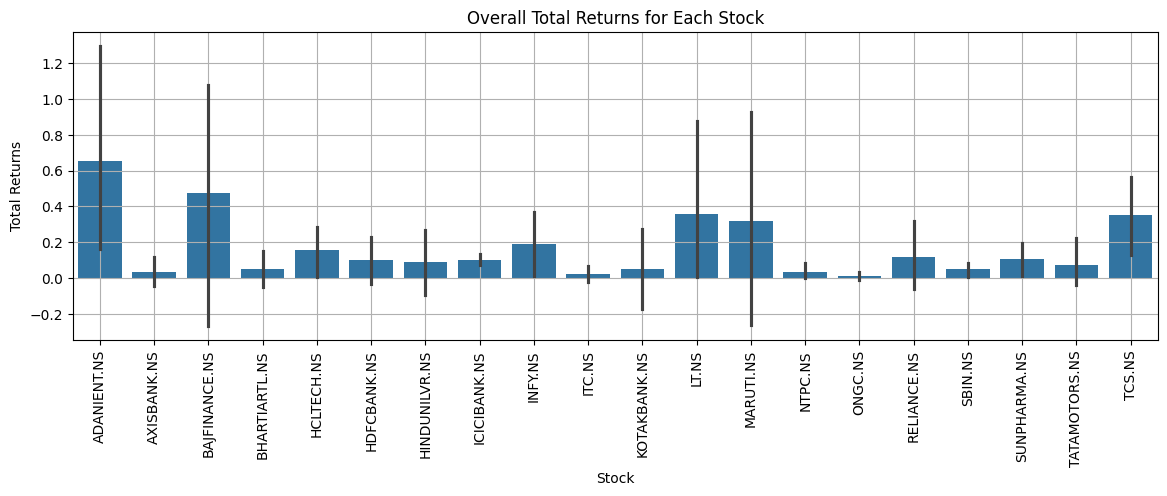

In [145]:
plt.figure(figsize=(14, 4))
sns.barplot(data=results_df, x='Stock', y='Total Returns')

plt.title('Overall Total Returns for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Total Returns')
plt.grid(True)
plt.xticks(rotation=90) 

plt.show()

The visualization presents the total returns of the top 20 NSE stocks over a specific period. Performance varies significantly across stocks, with some exhibiting substantial gains while others incurred losses. Banking and financial stocks generally outperformed IT and energy sectors during this timeframe. However, the visualization alone cannot provide a comprehensive understanding of stock performance and should be complemented with additional metrics and analysis.

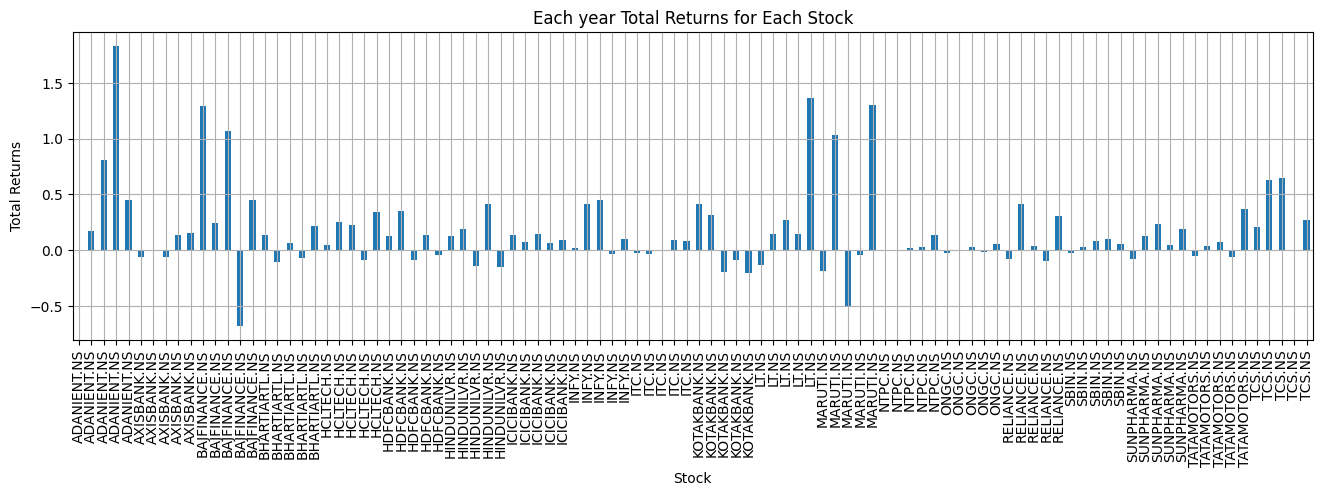

In [146]:
# Plot total returns for each stock
plt.figure(figsize=(16,4))
results_df.set_index('Stock')['Total Returns'].plot(kind='bar')
plt.title('Each year Total Returns for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Total Returns')
plt.grid(True)
plt.show()

Tish chart show the Total return on annual basis here is the most return come from Adanient in 2022 is aprox 2 however the most loss makingfor return from Bajajfinance in 2022


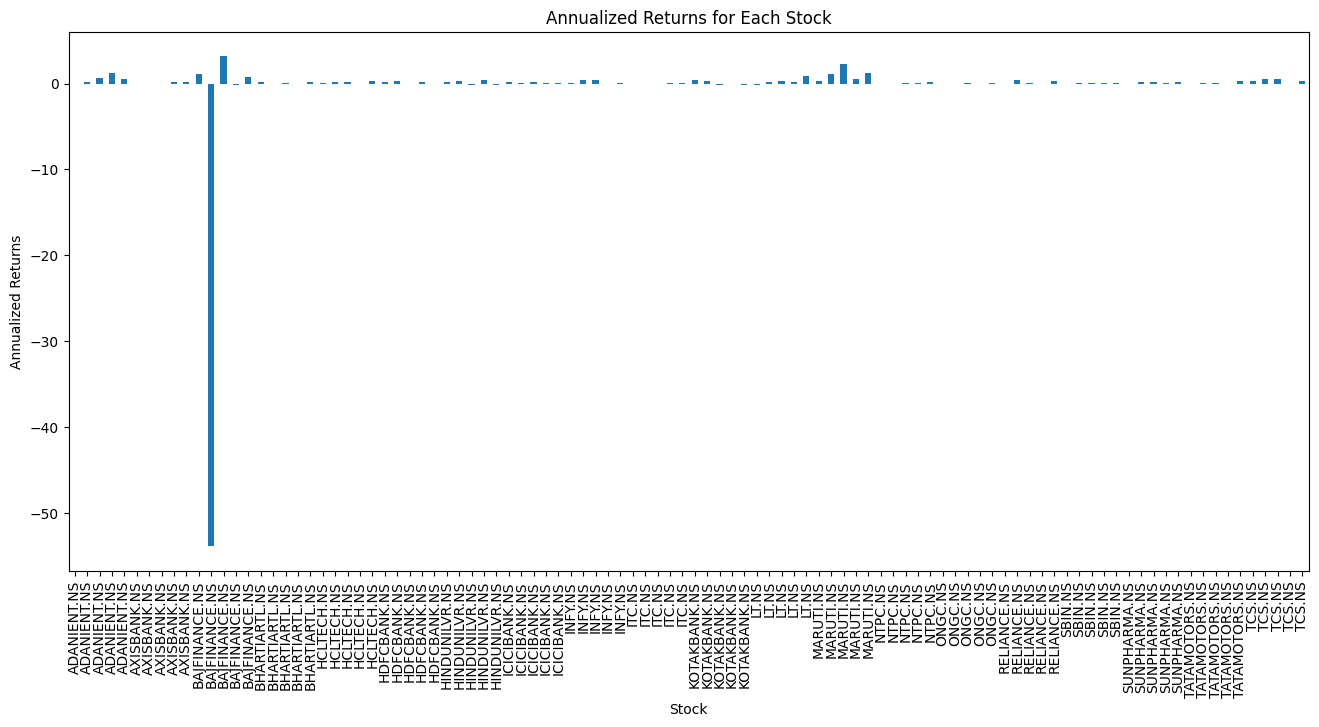

In [147]:
# Plot annualized returns for each stock
plt.figure(figsize=(16, 7))
results_df.set_index('Stock')['Annualized Returns'].plot(kind='bar')
plt.title('Annualized Returns for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Annualized Returns')
plt.show()

This chart shows the annualized return from companies here Bajajfinance on of the company which make a return  greater than -50. Apart from that every company make avg return .

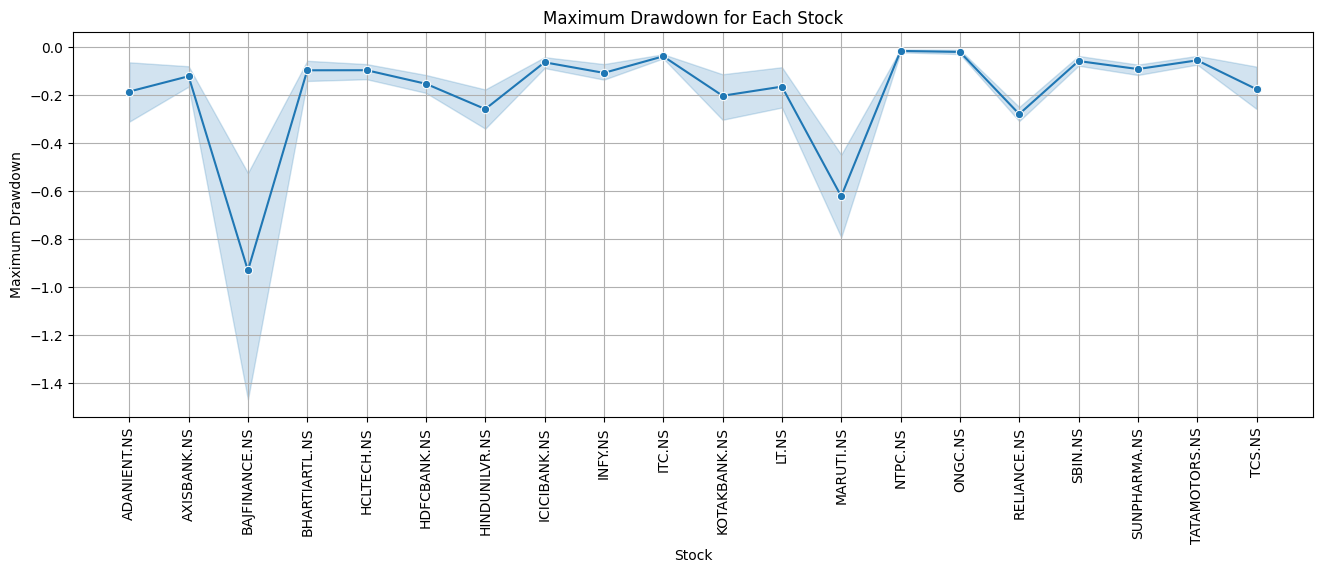

In [148]:
# Creating  the Seaborn line plot
plt.figure(figsize=(16, 5))
sns.lineplot(data=results_df, x='Stock', y='Max Drawdown', marker='o')

plt.title('Maximum Drawdown for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Maximum Drawdown')
plt.grid(True)
plt.xticks(rotation=90) 

plt.show()

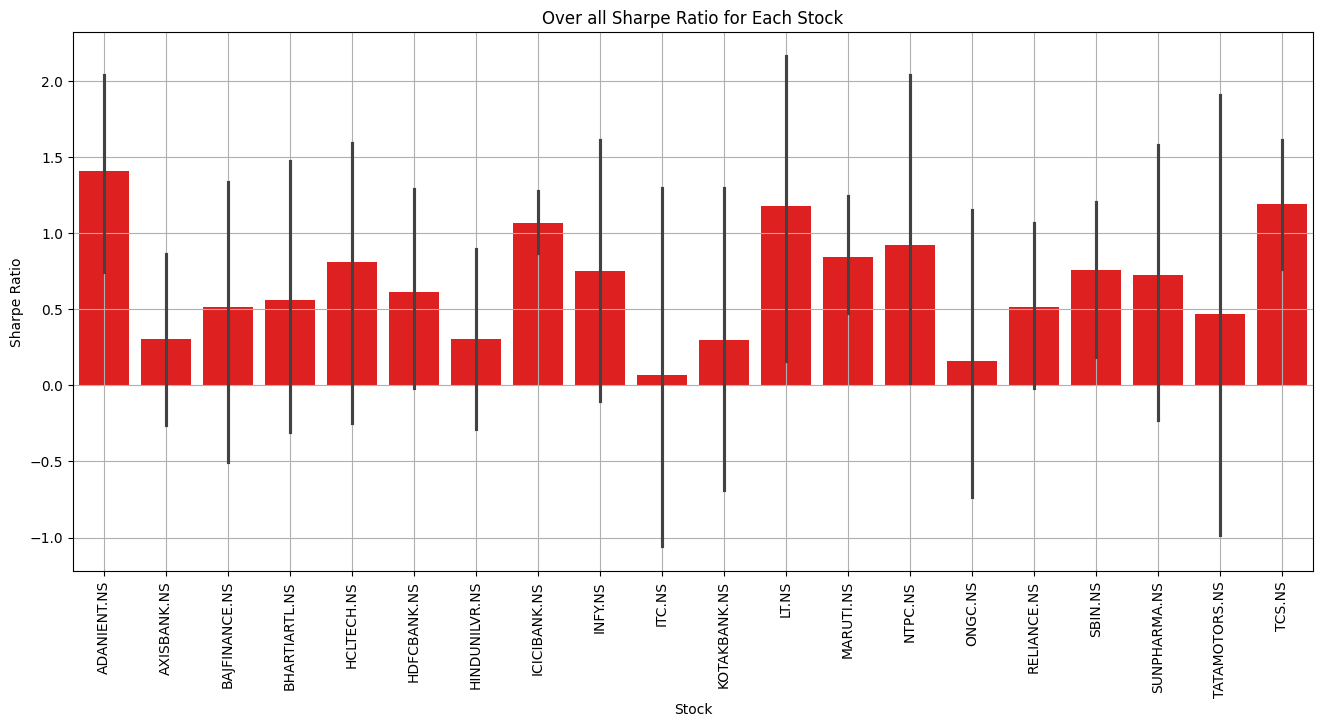

In [149]:
# Create the figure and the Seaborn bar plot
plt.figure(figsize=(16, 7))
sns.barplot(data=results_df, x='Stock', y='Sharpe Ratio', color='red')

plt.title('Over all Sharpe Ratio for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=90)  # Rotate stock names if they overlap
plt.grid(True)

# Show the plot
plt.show()

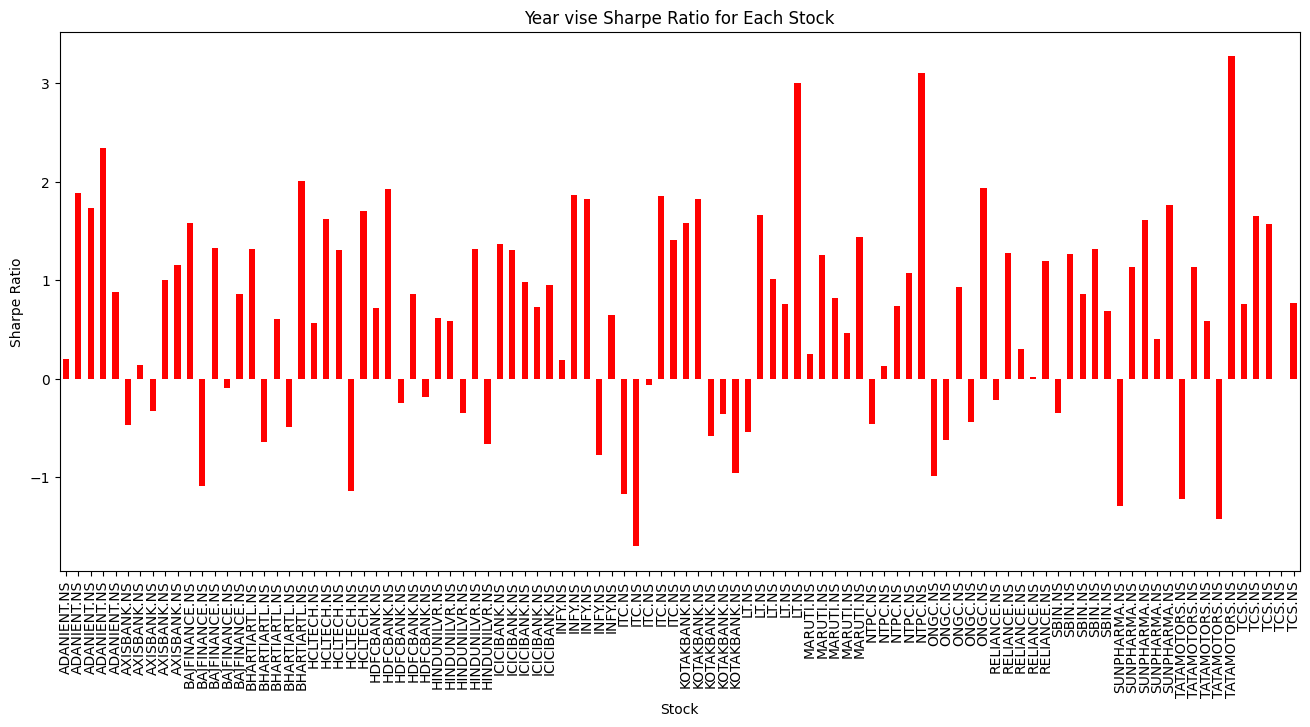

In [150]:
# Plot Sharpe Ratio for each stock
plt.figure(figsize=(16, 7))
results_df.set_index('Stock')['Sharpe Ratio'].plot(kind='bar',color='red')
plt.title('Year vise Sharpe Ratio for Each Stock')
plt.xlabel('Stock')
plt.ylabel('Sharpe Ratio')
plt.show()

##  Analyze the results, identifying strengths and weaknesses of the strategy.

In [152]:
# Strengths and weaknesses analysis
print("Strengths and Weaknesses of the Strategy:")

for index, row in results_df.iterrows():
    symbol = row['Stock']
    total_returns = row['Total Returns']
    annualized_returns = row['Annualized Returns']
    max_drawdown = row['Max Drawdown']
    sharpe_ratio = row['Sharpe Ratio']
    win_loss_ratio = row['Win/Loss Ratio']
    num_trades = row['Number of Trades']
    
    print(f"\nSymbol: {symbol}")
    print(f"Total Returns: {total_returns:.2f}")
    print(f"Annualized Returns: {annualized_returns:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Win/Loss Ratio: {win_loss_ratio:.2f}")
    print(f"Number of Trades: {num_trades}")

    if sharpe_ratio > 1:
        print("Strength: The strategy has a good risk-adjusted return.")
    else:
        print("Weakness: The strategy has a poor risk-adjusted return.")

    if win_loss_ratio > 0.5:
        print("Strength: The strategy has a higher win ratio.")
    else:
        print("Weakness: The strategy has a lower win ratio.")

    if num_trades < 50:
        print("Strength: The strategy does not overtrade.")
    else:
        print("Weakness: The strategy has too many trades, leading to higher transaction costs.")

Strengths and Weaknesses of the Strategy:

Symbol: ADANIENT.NS
Total Returns: 0.01
Annualized Returns: 0.01
Max Drawdown: -0.04
Sharpe Ratio: 0.20
Win/Loss Ratio: 0.32
Number of Trades: 3.0
Weakness: The strategy has a poor risk-adjusted return.
Weakness: The strategy has a lower win ratio.
Strength: The strategy does not overtrade.

Symbol: ADANIENT.NS
Total Returns: 0.17
Annualized Returns: 0.17
Max Drawdown: -0.03
Sharpe Ratio: 1.89
Win/Loss Ratio: 0.30
Number of Trades: 3.0
Strength: The strategy has a good risk-adjusted return.
Weakness: The strategy has a lower win ratio.
Strength: The strategy does not overtrade.

Symbol: ADANIENT.NS
Total Returns: 0.81
Annualized Returns: 0.68
Max Drawdown: -0.19
Sharpe Ratio: 1.73
Win/Loss Ratio: 0.82
Number of Trades: 1.0
Strength: The strategy has a good risk-adjusted return.
Strength: The strategy has a higher win ratio.
Strength: The strategy does not overtrade.

Symbol: ADANIENT.NS
Total Returns: 1.83
Annualized Returns: 1.19
Max Drawdown

## Discuss how market conditions (e.g., bull vs. bear markets) affected the strategy's performance

In [153]:
# Assuming 'df' is your DataFrame containing stock data
symbols = df["Symbol"].unique()

for symbol in symbols:
    stock_data = df[df["Symbol"] == symbol].copy()
    
    stock_data['daily_return'] = stock_data['Close'].pct_change()
    
    # rolling mean of daily returns
    rolling_mean_return = stock_data['daily_return'].rolling(window=20, min_periods=1).mean()
    
    # Determine market conditions based on the rolling mean return
    stock_data['market_condition'] = np.where(rolling_mean_return > 0, 'Bull', 'Bear')
    
    # Calculate average returns for bull and bear markets
    bull_market_returns = stock_data[stock_data['market_condition'] == 'Bull']['daily_return'].mean()
    bear_market_returns = stock_data[stock_data['market_condition'] == 'Bear']['daily_return'].mean()
    
    print(f"\nSymbol: {symbol}")
    print(f"Average Return in Bull Markets: {bull_market_returns:.2f}")
    print(f"Average Return in Bear Markets: {bear_market_returns:.2f}")
    if bull_market_returns > bear_market_returns:
        print("The strategy performs better in bull markets.")
    else:
        print("The strategy performs better in bear markets.")



Symbol: ADANIENT.NS
Average Return in Bull Markets: 0.01
Average Return in Bear Markets: -0.01
The strategy performs better in bull markets.

Symbol: AXISBANK.NS
Average Return in Bull Markets: 0.00
Average Return in Bear Markets: -0.00
The strategy performs better in bull markets.

Symbol: BAJFINANCE.NS
Average Return in Bull Markets: 0.00
Average Return in Bear Markets: -0.00
The strategy performs better in bull markets.

Symbol: BHARTIARTL.NS
Average Return in Bull Markets: 0.00
Average Return in Bear Markets: -0.00
The strategy performs better in bull markets.

Symbol: HCLTECH.NS
Average Return in Bull Markets: 0.00
Average Return in Bear Markets: -0.00
The strategy performs better in bull markets.

Symbol: HDFCBANK.NS
Average Return in Bull Markets: 0.00
Average Return in Bear Markets: -0.00
The strategy performs better in bull markets.

Symbol: HINDUNILVR.NS
Average Return in Bull Markets: 0.00
Average Return in Bear Markets: -0.00
The strategy performs better in bull markets.



## Suggest potential improvements or modifications to the strategy based on your analysis.

In [154]:
# Suggest potential improvements
print("\nPotential Improvements or Modifications:")

for index, row in results_df.iterrows():
    symbol = row['Stock']
    max_drawdown = row['Max Drawdown']
    win_loss_ratio = row['Win/Loss Ratio']
    num_trades = row['Number of Trades']

    print(f"\nSymbol: {symbol}")
    
    if max_drawdown < -0.2:
        print("Consider adding a stop-loss mechanism to limit drawdowns.")
    
    if win_loss_ratio < 0.5:
        print("Combine the strategy with additional indicators (e.g., RSI, MACD) to filter out bad trades.")
    
    if num_trades > 50:
        print("Reduce the number of trades by adjusting the moving average windows or adding filters for trade signals.")


Potential Improvements or Modifications:

Symbol: ADANIENT.NS
Combine the strategy with additional indicators (e.g., RSI, MACD) to filter out bad trades.

Symbol: ADANIENT.NS
Combine the strategy with additional indicators (e.g., RSI, MACD) to filter out bad trades.

Symbol: ADANIENT.NS

Symbol: ADANIENT.NS
Consider adding a stop-loss mechanism to limit drawdowns.

Symbol: ADANIENT.NS
Consider adding a stop-loss mechanism to limit drawdowns.
Combine the strategy with additional indicators (e.g., RSI, MACD) to filter out bad trades.

Symbol: AXISBANK.NS
Combine the strategy with additional indicators (e.g., RSI, MACD) to filter out bad trades.

Symbol: AXISBANK.NS
Combine the strategy with additional indicators (e.g., RSI, MACD) to filter out bad trades.

Symbol: AXISBANK.NS
Combine the strategy with additional indicators (e.g., RSI, MACD) to filter out bad trades.

Symbol: AXISBANK.NS
Combine the strategy with additional indicators (e.g., RSI, MACD) to filter out bad trades.

Symbol: 